In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from fredapi import Fred
from dateutil import parser
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
import statsmodels.api as sm

fred = Fred(api_key='b54f98de75f79847124426ad6525099f')

# Forecasting Equity Market Trends Based on Economic Indicators

In [146]:
# List of Yahoo Finance tickers and corresponding FRED series IDs
tickers = {
    'sp500': '^GSPC', # sp 500 predicted variable
    't_bill_10y': '^TNX',     # Monetary Supply
    'crude_oil' : 'CL=F', # Crude Oil
}

fred_series = {
    # General Macroeconomic
    'cpi' : 'CPIAUCSL',
    'ipi' : 'INDPRO',
    # Labor Market
    'unemployment_rate' : 'UNRATE',
    'unemployment_level' :'UNEMPLOY',
    'employment_level' : 'CE16OV',
    'labor_force_rate' : 'CIVPART',
    
    # Real Estate
    'house_start' : 'HOUST',
    'house_permit' : 'PERMIT',
    
    # Credit Market
    'interbank_interet_rates': 'IR3TIB01USM156N',
    't_bill_3m' :'TB3MS',
    'comercial_industrial_loans' : 'BUSLOANS',
    'bank_prime_loan_rate' : 'MPRIME',
    'bank_credit' : 'LOANINV',
    
    # Monetary Supply
    'm1' : 'M1SL',
    'm2' : 'M2SL',
    'fund_rate' : 'FEDFUNDS',
    'currency_circulation' : 'CURRCIR',
    
    # Consumer Financial Behavior
    'personal_saving_rate' : 'PSAVERT',
    'pce' : 'PCE',
    'real_disposable_personal_income' : 'DSPIC96',
    'personal_saving' : 'PMSAVE',
    'demand_deposits' : 'DEMDEPSL',
    
    # Commodity market
    'vehicle_sales' : 'TOTALSA'
}

# Historical range
start_date = "1990-01-01"
end_date = "2023-12-31"

# Fetch Yahoo Finance data
yf_data = pd.DataFrame()
for name, ticker in tickers.items():
    cleab_yf_df = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    yf_data[name] = cleab_yf_df

# Fetch FRED data
fred_data = pd.DataFrame()
for name, series_id in fred_series.items():
    clean_fred_df = fred.get_series(series_id, observation_start=start_date)
    clean_fred_df = clean_fred_df.resample('M').last()
    fred_data[name] = clean_fred_df

raw_data  = pd.concat([yf_data, fred_data], axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [147]:
# Assuming combined_data is your DataFrame

# Forward fill to handle missing values, if appropriate
combined_data = raw_data.copy()
combined_data = combined_data.ffill()

# Assuming 21 trading days in a month, calculate the price 3 months later
forward_3m_price = combined_data['sp500'].shift(-61)

# Calculate the percentage change to get the forward 3-month return
combined_data['forward_3m_return'] = (forward_3m_price - combined_data['sp500']) / combined_data['sp500']

# Convert to binary: 1 if the return is positive, 0 if negative or no change
combined_data['price_trend'] = (combined_data['forward_3m_return'] > 0).astype(int)

# Drop the NA values that result from the shift operation
# Also, drop 'sp500' and 'forward_3m_return' as they are no longer needed
combined_data.drop(columns=['sp500', 'forward_3m_return'], inplace=True)
combined_data.dropna(inplace=True)

In [148]:
# Summary Statistics
summary_statistics = combined_data.describe()
summary_statistics

,t_bill_10y,crude_oil,cpi,ipi,unemployment_rate,unemployment_level,employment_level,labor_force_rate,house_start,house_permit,...,m2,fund_rate,currency_circulation,personal_saving_rate,pce,real_disposable_personal_income,personal_saving,demand_deposits,vehicle_sales,price_trend
count,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,...,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.000000,5958.00000,5958.000000,5958.000000
mean,3.150903,64.115134,227.499668,97.122945,5.817036,8999.915408,146130.284827,64.252165,1294.642497,1352.344411,...,11069.764334,1.667429,1237.774673,5.772256,11470.159886,13300.818127,780.533736,1291.37949,15.905272,0.650050
std,1.233088,25.474669,33.773925,4.968989,1.974112,3028.631919,7389.641875,1.738337,443.041737,458.073152,...,4976.615909,1.842882,534.164034,3.305683,3097.336275,2065.876020,675.509886,1398.87348,2.247862,0.476994
min,0.499000,-37.630001,172.700000,84.597900,3.400000,5534.000000,133185.000000,60.100000,478.000000,513.000000,...,4789.400000,0.050000,569.313000,1.400000,6768.500000,10035.900000,128.900000,296.20000,8.834000,0.000000
25%,2.141000,44.742501,201.300000,92.862100,4.400000,6792.250000,139492.000000,62.800000,976.000000,1015.000000,...,6806.900000,0.140000,793.735500,4.400000,9231.800000,11744.400000,428.300000,330.90000,14.769000,0.000000
50%,3.009000,62.014999,228.524000,98.466900,5.400000,8000.000000,144802.000000,63.800000,1276.000000,1338.000000,...,9830.600000,1.010000,1095.166000,5.400000,10989.800000,12893.400000,673.800000,780.60000,16.657000,1.000000
75%,4.187000,83.570000,249.529000,101.484800,6.700000,10538.000000,151793.000000,66.100000,1620.000000,1691.000000,...,13912.300000,2.407500,1616.281000,6.300000,13540.600000,14921.100000,873.600000,1474.40000,17.514000,1.000000
max,5.892000,145.289993,308.850000,104.118100,14.800000,23090.000000,161866.000000,67.200000,2273.000000,2263.000000,...,21703.600000,6.540000,2342.699000,32.000000,18858.900000,20422.600000,5976.400000,5181.20000,22.055000,1.000000


In [149]:
combined_data

,t_bill_10y,crude_oil,cpi,ipi,unemployment_rate,unemployment_level,employment_level,labor_force_rate,house_start,house_permit,...,m2,fund_rate,currency_circulation,personal_saving_rate,pce,real_disposable_personal_income,personal_saving,demand_deposits,vehicle_sales,price_trend
2000-08-23,5.725,32.049999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-24,5.716,31.629999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-25,5.721,32.049999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-28,5.766,32.869999,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
2000-08-29,5.808,32.720001,172.700,92.8458,4.0,5747.0,136531.0,66.9,1463.0,1542.0,...,4789.4,6.54,571.216,4.7,6768.5,10035.9,347.9,333.1,17.316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,3.886,75.570000,307.917,102.4301,3.7,6262.0,161866.0,62.8,1560.0,1467.0,...,20767.4,5.33,2327.155,4.1,18858.9,16919.9,839.8,4996.4,15.798,0
2023-12-27,3.789,74.110001,307.917,102.4301,3.7,6262.0,161866.0,62.8,1560.0,1467.0,...,20767.4,5.33,2327.155,4.1,18858.9,16919.9,839.8,4996.4,15.798,0
2023-12-28,3.850,71.769997,307.917,102.4301,3.7,6262.0,161866.0,62.8,1560.0,1467.0,...,20767.4,5.33,2327.155,4.1,18858.9,16919.9,839.8,4996.4,15.798,0
2023-12-29,3.866,71.650002,307.917,102.4301,3.7,6262.0,161866.0,62.8,1560.0,1467.0,...,20767.4,5.33,2327.155,4.1,18858.9,16919.9,839.8,4996.4,15.798,0


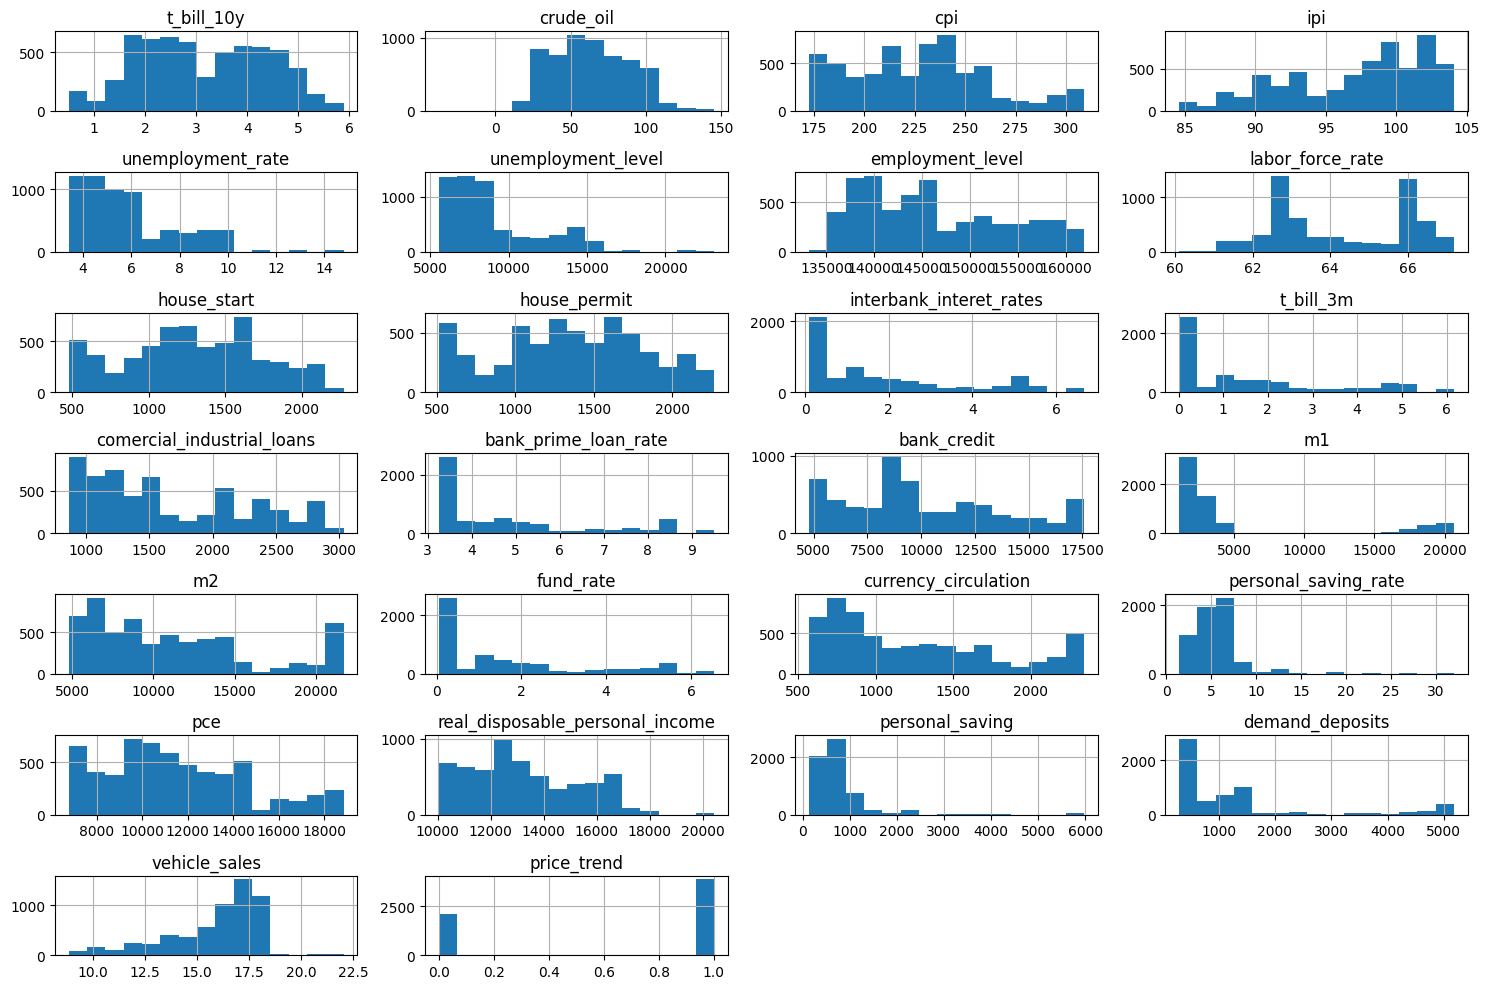

In [150]:
# Distribution Analysis - Histograms for each variable
combined_data.hist(bins=15, figsize=(15, 10), layout=(7, 4))
plt.tight_layout()
plt.show()

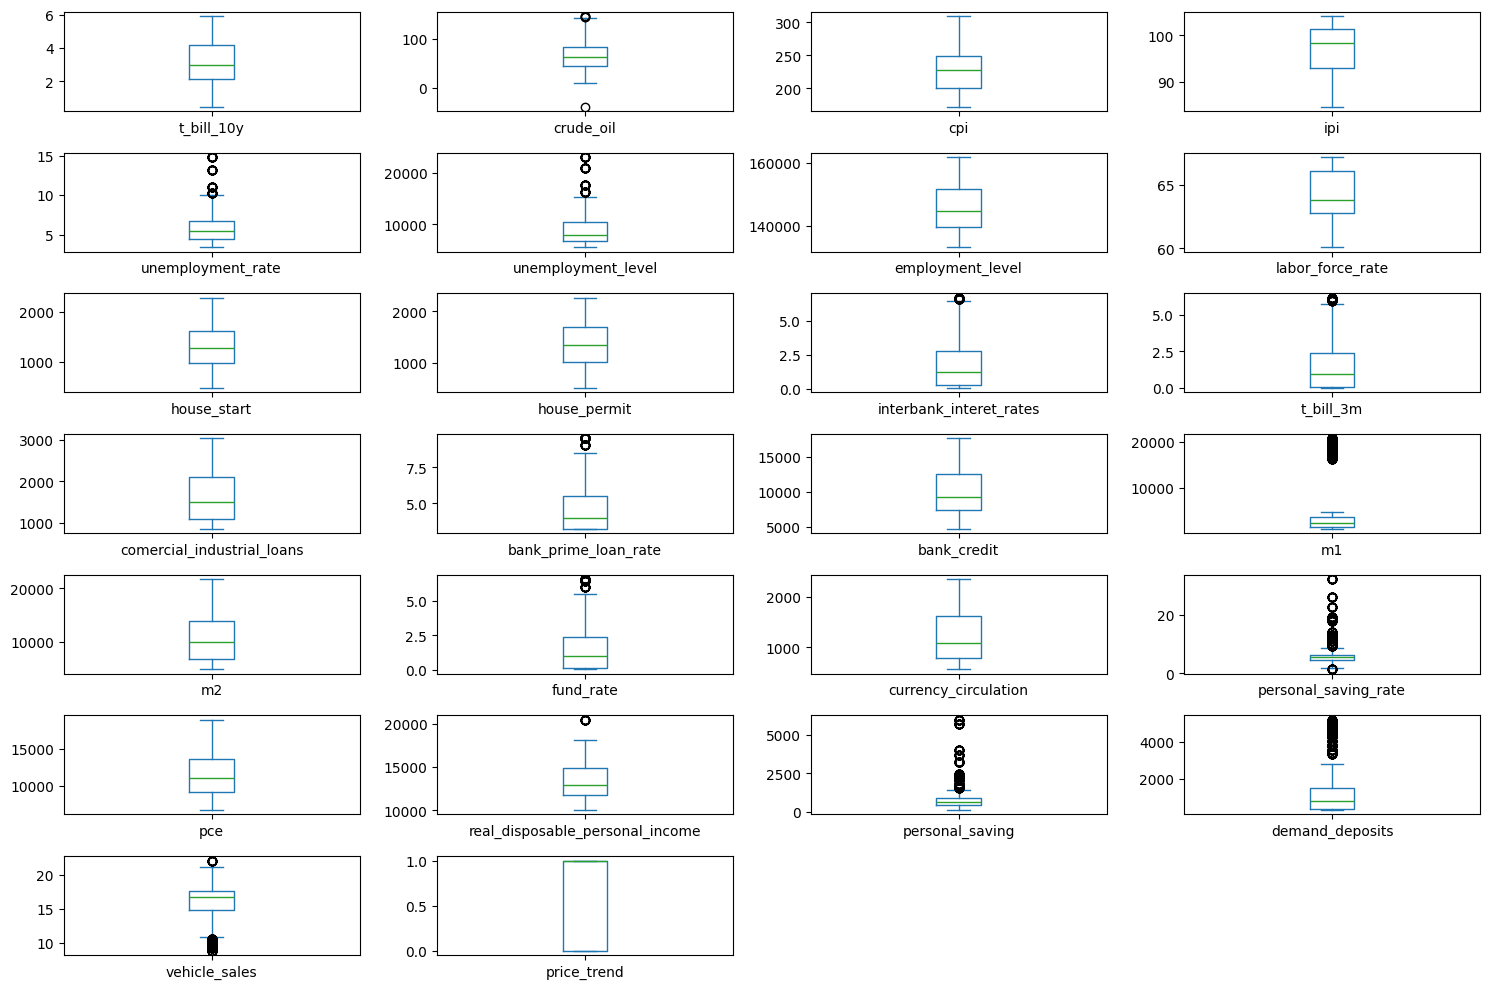

In [151]:
# Boxplot for each variable to identify outliers
combined_data.plot(kind='box', subplots=True, layout=(7, 4), figsize=(15, 10))
plt.tight_layout()
plt.show()

In [167]:
from scipy.stats import pointbiserialr
import pandas as pd

def point_biserial_correlation(data, numerical_columns, target_column):
    results = []

    for column in numerical_columns:
        coef, p_val = pointbiserialr(data[column], data[target_column])
        results.append([column, coef, p_val])

    results_df = pd.DataFrame(results, columns=['Feature', 'Point-Biserial Coefficient', 'P-Value'])
    return results_df

# Assuming 'combined_data' is your DataFrame
# Calculate Point-Biserial Correlation Coefficient for each numerical feature against the target
numerical_columns = list(combined_data.drop('price_trend', axis=1).columns)
point_biserial_results_df = point_biserial_correlation(combined_data, numerical_columns, 'price_trend')

# Display sorted results
sorted_results_df = round(point_biserial_results_df.sort_values(by='Point-Biserial Coefficient', ascending=False), 1)
print(sorted_results_df)


                            Feature  Point-Biserial Coefficient  P-Value
19             personal_saving_rate                         0.2      0.0
22                  personal_saving                         0.2      0.0
5                unemployment_level                         0.2      0.0
4                 unemployment_rate                         0.2      0.0
21  real_disposable_personal_income                         0.1      0.0
14                      bank_credit                         0.1      0.0
18             currency_circulation                         0.1      0.0
2                               cpi                         0.1      0.0
16                               m2                         0.1      0.0
12       comercial_industrial_loans                         0.1      0.0
20                              pce                         0.1      0.0
6                  employment_level                         0.0      0.0
3                               ipi                

In [170]:
# Define the threshold for relevance
threshold = 0.1

# Filter the features based on the threshold
relevant_features = sorted_results_df[sorted_results_df['Point-Biserial Coefficient'] >= threshold]['Feature'].tolist()
relevant_features

['personal_saving_rate',
 'personal_saving',
 'unemployment_level',
 'unemployment_rate',
 'real_disposable_personal_income',
 'bank_credit',
 'currency_circulation',
 'cpi',
 'm2',
 'comercial_industrial_loans',
 'pce']

In [201]:
#numerical_relevant_features
features_data = combined_data[relevant_features+['price_trend']]

In [212]:
# Splitting the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(features_data.drop('price_trend', axis=1),
                                                                    features_data['price_trend'], 
                                                                    test_size=0.3, 
                                                                    random_state=42)

# Displaying the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4170, 11), (1788, 11), (4170,), (1788,))

In [213]:
# Handling imbalanced data

y_train.value_counts()

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote.values.ravel())

# Predicting on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluating the model
accuracy_log_reg = "Accuracy of Logistic Regression: {:.2f}%".format(accuracy_score(y_test, y_pred_log_reg) * 100)
report_log_reg = classification_report(y_test, y_pred_log_reg, output_dict=True)

# Displaying the accuracy and the classification report
print("Accuracy:", accuracy_log_reg)
print("Classification Report:")
print(pd.DataFrame(report_log_reg).transpose())

Accuracy: Accuracy of Logistic Regression: 60.91%
Classification Report:
              precision    recall  f1-score     support
0              0.460626  0.682109  0.549903   626.00000
1              0.768873  0.569707  0.654474  1162.00000
accuracy       0.609060  0.609060  0.609060     0.60906
macro avg      0.614750  0.625908  0.602188  1788.00000
weighted avg   0.660952  0.609060  0.617862  1788.00000


C:\anaconda\envs\env_ml\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [215]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluating the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Displaying the accuracy and the classification report
print("Accuracy of Random Forest:", accuracy_rf)
print("Random Forest Classifier Classification Report:")
print(pd.DataFrame(report_rf).transpose())


Accuracy of Random Forest: 0.9093959731543624
Random Forest Classifier Classification Report:
              precision    recall  f1-score      support
0              0.841176  0.913738  0.875957   626.000000
1              0.951264  0.907057  0.928634  1162.000000
accuracy       0.909396  0.909396  0.909396     0.909396
macro avg      0.896220  0.910397  0.902296  1788.000000
weighted avg   0.912721  0.909396  0.910191  1788.000000


In [216]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the model with the SMOTE-resampled training data
svm_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluating the model
accuracy_svm = "Accuracy of SVM: {:.2f}%".format(accuracy_score(y_test, y_pred_svm) * 100)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Displaying the accuracy and the classification report
print("Accuracy:", accuracy_svm)
print("Classification Report:")
print(pd.DataFrame(report_svm).transpose())


Accuracy: Accuracy of SVM: 64.49%
Classification Report:
              precision    recall  f1-score      support
0              0.494786  0.682109  0.573539   626.000000
1              0.784865  0.624785  0.695736  1162.000000
accuracy       0.644855  0.644855  0.644855     0.644855
macro avg      0.639825  0.653447  0.634637  1788.000000
weighted avg   0.683305  0.644855  0.652953  1788.000000


In [217]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the model with the SMOTE-resampled training data
nb_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Evaluating the model
accuracy_nb = "Accuracy of Naive Bayes: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100)
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)

# Displaying the accuracy and the classification report
print("Accuracy:", accuracy_nb)
print("Classification Report:")
print(pd.DataFrame(report_nb).transpose())


Accuracy: Accuracy of Naive Bayes: 49.50%
Classification Report:
              precision    recall  f1-score      support
0              0.390340  0.787540  0.521969   626.000000
1              0.746667  0.337349  0.464730  1162.000000
accuracy       0.494966  0.494966  0.494966     0.494966
macro avg      0.568504  0.562445  0.493350  1788.000000
weighted avg   0.621913  0.494966  0.484770  1788.000000


In [218]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Train the model with the SMOTE-resampled training data
gb_classifier.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_gb = gb_classifier.predict(X_test)

# Evaluating the model
accuracy_gb = "Accuracy of Gradient Boosting: {:.2f}%".format(accuracy_score(y_test, y_pred_gb) * 100)
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)

# Displaying the accuracy and the classification report
print("Accuracy:", accuracy_gb)
print("Classification Report:")
print(pd.DataFrame(report_gb).transpose())


Accuracy: Accuracy of Gradient Boosting: 88.31%
Classification Report:
              precision    recall  f1-score     support
0              0.793249  0.900958  0.843680   626.00000
1              0.942433  0.873494  0.906655  1162.00000
accuracy       0.883110  0.883110  0.883110     0.88311
macro avg      0.867841  0.887226  0.875167  1788.00000
weighted avg   0.890202  0.883110  0.884607  1788.00000
